### Cloud Mask Project

Abstract of the project available in https://docs.google.com/document/d/1T-uMGFXgOIb0-DgFu4H25VU6gPrn4d5ybH_vMQYK2aI/edit

To do:
- (Done) Find the way to login to Earthdata just once for all the VIIRS + ATL06 retrievals
- Add all the features from ALT06 we find interesting and re-order columns
- Add time efficiently to ATL06 data frames (problem with timestamps)
- (Done) check if the time window is correct (how to access date and time in ATL?)
- Raise a better error messege for the case of missing data
- (Done) Index in the ATL06 dataframes. There are a lot of repetitions
- (Done) Grid correction: do the vertices on VIIDS correspond to the center of the cell or to the real vertices of a cell? In that case, we need to shift the net.
(Answer: this is for MODIS)
- Change Ball Tree for something faster
- Which is a good spatial window for VIIRS? 1km? How to go from (delta_lat, delta_lon) to delta_meters?
- Should I be careful with the VIIRS images we use? Focus maybe on some moment of the year + some region (Antarctice y/o Greenland)
- Is there any way to access VIIRS metadata?
- Parallelize each VIIRS call

In [1]:
from icepyx import icesat2data as ipd
from pathlib import Path
import h5py
import os
import numpy as np
import pandas as pd
import pyproj
from astropy.time import Time
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

In [2]:
from utils import get_file_in_directory, is_file_in_directory, gps2dyr
from utils_atl06 import read_atl06_fromfile, atl06_2_df, read_atl06
from utils_viirs import associate

### ATL06 Retrieval Example

In [3]:
spatial_extent = [ -50.71,  65.73, -45.32,  68.08]

date_range = ['2019-06-01','2019-06-01']
#date_range = ['2019-08-01','2019-08-05']

df = read_atl06(spatial_extent, date_range, time_start="06:00:00", time_end="18:00:00")
#df = read_atl06(spatial_extent, date_range, time_start="06:00:00", time_end="07:00:00")

['ATL06_20190601071608_09780303_003_01.h5']
You already donwload all the requiered files


In [4]:
df

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,c_flg_asr,c_flg_atm,msw,bsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final
0,gt1l,2019-06-01 07:18:41.747013,371978,66.862169,-45.326436,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
1,gt1l,2019-06-01 07:18:41.749913,371979,66.862351,-45.326488,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
2,gt1l,2019-06-01 07:18:41.761213,371983,66.863066,-45.326704,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
3,gt1l,2019-06-01 07:18:41.924563,372041,66.873399,-45.329752,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
4,gt1l,2019-06-01 07:18:42.076715,372095,66.883032,-45.332678,3.402823e+38,3.402823e+38,1,2,0.410136,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,22,3.402823e+38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18832,gt3r,2019-06-01 07:19:01.191144,378767,68.079176,-45.542332,2.108602e+03,5.460238e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.377494e+06,9.003687e+05,71,3.000000e+00
18833,gt3r,2019-06-01 07:19:01.193960,378768,68.079354,-45.542388,2.108555e+03,3.353689e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.353846e+06,9.003771e+05,99,3.000000e+00
18834,gt3r,2019-06-01 07:19:01.196774,378769,68.079533,-45.542444,2.108532e+03,2.669299e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.224596e+06,9.003854e+05,116,3.000000e+00
18835,gt3r,2019-06-01 07:19:01.199586,378770,68.079711,-45.542499,2.108602e+03,2.575822e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.142260e+06,9.003946e+05,116,3.000000e+00


In [5]:
df.t_year[0]

Timestamp('2019-06-01 07:18:41.747013')

### VIIRS Asimilation

In [6]:
def associate2(rad_1, rad_2, k_nn = 1):
    
    """
    Given two grids rad_1 and rad_2, this associates each point in rad_2 to the k-nearest neighbours in
    rad_1.
    """
    
    # Room to improvement:
    # - Run the Ball tree on the smallest net
    # - Use something more efficient than a Ball Tree, like a binary search.
    
    # Build Ball Tree
    Ball = BallTree(rad_1, metric='haversine')
    
    # Searching Data
    distances, indices = Ball.query(rad_2, 
                                    k = k_nn,
                                    breadth_first = True,
                                    return_distance = True) 
    
    assert rad_2.shape[0] == indices.shape[0]
    
    return distances, indices

####################################

def ATL06_from_VIIRS(Cfiles, hr=1, cl_var='Integer_Cloud_Mask',toff_var='VIIRS_Offset'):
    '''
    Read in each VIIRS cloud mask file and try to assimilate it to data in 
    Icesat-2. Data points that coincide in time (within a window) and space. Offset
    in time is calculated.
    
    Input:
        - Cfiles = list of VIIRS file paths
        - hr = hours, temporal search window
        - cl_var = column name for VIIRS data
        - toff_var = column name for time offset between VIIRS and Icesat-2 data
    '''
    
 

In [ ]:
hr = 0.5
cld_t_var = 'VIIRS_offset'
V_variable = 'Integer_Cloud_Mask'
k = 3
tolerance_spatial_dismatch = 1 # in kilometers 
radii = 6371


Vfiles = get_file_in_directory('VIIRS_data/')


VIIRS_2_ATL06 = {}

for Vfile in Vfiles: 

    """
    Atmospheric product retrieval.
    
    This part should be return the same for all the external producs:
    
        - f_t: timestamp where the product was recorded
        - latS : 2-dimensional np.array with the latitudes
        - lonS : 2-dimensional np.array with the longitudes
        - extract : np.array with the label of the product
    
    """
    
    print(Vfile)
    
    # Temportal properties
    f_ = h5py.File(Vfile)     # VIIRS file 
    f_t = int(Vfile[-33:-26]+Vfile[-25:-21])
    f_t = pd.to_datetime(f_t, format="%Y%j%H%M")
    
    # Spatial properties
    latS = f_["geolocation_data"]["latitude"][:]
    lonS = f_["geolocation_data"]["longitude"][:]
    assert latS.shape == lonS.shape, "latS and lonS must have the same shape"
    
    # Label
    extract = f_['geophysical_data'][V_variable].value
    assert extract.shape == latS.shape, "Labels and latS must have the same shape"
    
    
    """
    Preprocesing of the atmospheric product 
    """

    # I change the coordinates to radians and I stack pairs of (latitude, longitede) 
    
    S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
    S_rad *= np.pi / 180.

    
    """
    ATL06 Retrieval
    """

    # Temporal search window for 
    start = f_t - pd.DateOffset(hours=hr)
    end   = f_t + pd.DateOffset(hours=hr)
    
    start_date_str = start.strftime('%Y-%m-%d')
    end_date_str   = end.strftime('%Y-%m-%d')
    start_time_str = start.strftime('%H:%M:%S')
    end_time_str   = end.strftime('%H:%M:%S')
    
    # I should be able to do this defining a rectangle that coincides with VIIRS, instead of a rectangle
    # defined by the parallels and meridians 
    lat_min = np.min(latS)
    lat_max = np.max(latS)
    lon_min = np.min(lonS)
    lon_max = np.max(lonS)
    
    spatial_extent = [lon_min, lat_min, lon_max, lat_max]
    spatial_extent = [float(x) for x in spatial_extent]   # I should not do once Issue 82 is solved 
    
    date_range = [start_date_str, end_date_str]
    
    #df = df_preprocessed    
    df = read_atl06(spatial_extent = spatial_extent,
                    date_range = date_range,
                    time_start = start_time_str,
                    time_end = end_time_str,
                    path = "./new_ATL06/")# + Vfile)
    
    # I should add an extra filter here to be sure that all measuraments are in the desired temporal window
    # ...
    
    latF = df.lat.values 
    lonF = df.lon.values
    
    F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
    F_rad *= np.pi / 180.

    """
    Assimilation
    """
    
    # Label Assimilation
    
    distances, indices = associate(S_rad, F_rad, k_nn=k)
    
    for i in range(indices.shape[1]):
        
        new_column = extract.ravel()[indices[:, i]]
        df[ V_variable + "_k" + str(i + 1) ] = new_column
        df[ V_variable + "_k" + str(i + 1) + "_dist" ] = distances[:, i]
        
    # I filter ATL points outside the VIIRS Image
    df = df[ df[V_variable + "_k1_dist"] < tolerance_spatial_dismatch / radii ]
        
    # Difference on time assimilation ....
    #f_t_np = np.datetime64(f_t)
    #df["delta_assim"] = abs( df.t_year - f_t_np ) / np.timedelta64(1,'m') 
    df["delta_assim"] = abs( df.t_year - f_t ) / np.timedelta64(1,'m') 

    
    VIIRS_2_ATL06[Vfile] = df
    
    #break

VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019255.1518.001.2019256010721.nc


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['ATL06_20190912145647_11690402_003_01.h5', 'ATL06_20190912150518_11690403_003_01.h5', 'ATL06_20190912151043_11690404_003_01.h5', 'ATL06_20190912151552_11690405_003_01.h5']
Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000769936
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  complete_with_errors
NSIDC provided these error messages:
['178136988:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '178146658:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT6.120S',
 'ICESAT2']
Your order is: complete_with_errors
Beginning download of zipped output...
Data request 5000000769936 of  1  order(s) is downloaded.
Download complete
ATL06_20190912145647_11690402_003_01.h5  not found
ATL06_20190912150518_11690403_003_0

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['ATL06_20200409162635_02160703_003_01.h5']
You already donwload all the requiered files


In [124]:
VIIRS_2_ATL06.keys()

dict_keys(['VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019255.1518.001.2019256010721.nc', 'VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2020105.0448.001.2020105125805.nc', 'VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2020075.1730.001.2020076010547.nc'])

In [79]:
df = VIIRS_2_ATL06[list(VIIRS_2_ATL06.keys())[0]]

In [80]:
np.sum(df.Integer_Cloud_Mask_k1 == df.Integer_Cloud_Mask_k2) / df.shape[0]

0.8699469629514924

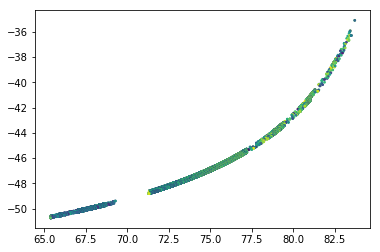

In [81]:
plt.scatter( df.lat[::10], df.lon[::10], c = df.Integer_Cloud_Mask_k1_dist[::10] , s = 3 )

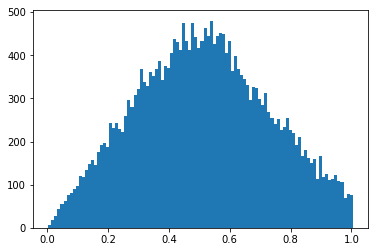

In [83]:
plt.hist(df.Integer_Cloud_Mask_k1_dist[::10] * 6400, 100);

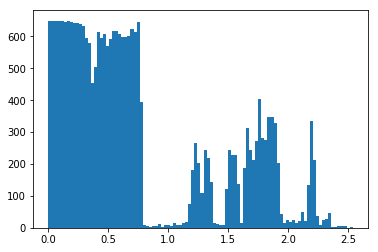

In [84]:
plt.hist(df.delta_assim[::10], 100);

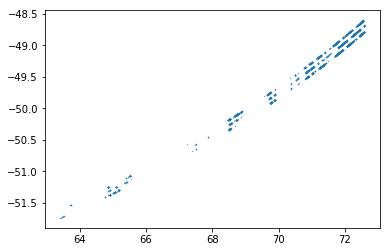

In [110]:
plt.scatter(df.lat[::10], df.lon[::10], s = 0.1)

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


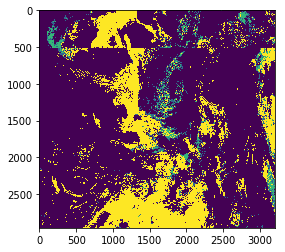

In [85]:
cloud_var = 'Integer_Cloud_Mask'

img = h5py.File(Vfiles[0])
Vdata = img['geophysical_data'][cloud_var].value
#plt.imshow(Vdata[1700:2200,2500:])
plt.imshow(Vdata)

In [124]:
region_a = ipd.Icesat2Data("ATL06", spatial_extent, date_range, start_time_str, end_time_str)
region_a.avail_granules(ids=True)
print("HOLA")
print(region_a.avail_granules(ids=True))

if len(region_a.avail_granules(ids=True)) == 0:
    print("No granules for this specification")


region_a.earthdata_login('fsapienza', 'fsapienza@berkeley.edu')
#region_a.order_vars.avail(options=True)
region_a.order_vars.append(var_list=['latitude','longitude','h_li'])
region_a.subsetparams(Coverage=region_a.order_vars.wanted)
region_a.order_granules()
region_a.download_granules(path="./new_ATL06")

HOLA
['ATL06_20190601035904_09760302_003_01.h5']


Earthdata Login password:  ···········


Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000725108
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  failed
NSIDC provided these error messages:
['178070332:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT0.887S',
 'ICESAT2']
Request failed.


AttributeError: 'Granules' object has no attribute 'orderIDs'

In [102]:
np.max(latS)

87.55718

In [125]:
start_time_str, end_time_str

('03:36:00', '04:36:00')

In [32]:
hr = 0.5
#cloud_var = 'Integer_Cloud_Mask'
cld_t_var = 'VIIRS_offset'
Vfiles = get_file_in_directory('VIIRS_data/')
V_variable = 'Integer_Cloud_Mask'
k = 3
tolerance_spatial_dismatch = 1 # in kilometers 
radii = 6371

VIIRS_2_ATL06 = {}

for Vfile in Vfiles: 

    """
    Atmospheric product retrieval.
    
    This part should be return the same for all the external producs:
    
        - f_t: timestamp where the product was recorded
        - latS : 2-dimensional np.array with the latitudes
        - lonS : 2-dimensional np.array with the longitudes
        - extract : np.array with the label of the product
    
    """
    
    print(Vfile)
    
    try:
    
        # Temportal properties
        f_ = h5py.File(Vfile)     # VIIRS file 
        f_t = int(Vfile[-33:-26]+Vfile[-25:-21])
        f_t = pd.to_datetime(f_t, format="%Y%j%H%M")

        # Spatial properties
        latS = f_["geolocation_data"]["latitude"][:]
        lonS = f_["geolocation_data"]["longitude"][:]
        assert latS.shape == lonS.shape, "latS and lonS must have the same shape"

        # Label
        extract = f_['geophysical_data'][V_variable].value
        assert extract.shape == latS.shape, "Labels and latS must have the same shape"


        """
        Preprocesing of the atmospheric product 
        """

        # I change the coordinates to radians and I stack paors of (latitude, longitede) 

        S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
        S_rad *= np.pi / 180.

        # Building Ball Tree
        #S_Ball = BallTree(S_rad,metric='haversine')

        """
        ATL06 Retrieval
        """

        # Temporal search window for 
        start = f_t - pd.DateOffset(hours=hr)
        end   = f_t + pd.DateOffset(hours=hr)

        start_date_str = start.strftime('%Y-%m-%d')
        end_date_str   = end.strftime('%Y-%m-%d')
        start_time_str = start.strftime('%H:%M:%S')
        end_time_str   = end.strftime('%H:%M:%S')

        # I should be able to do this defining a rectangle that coincides with VIIRS, instead of a rectangle
        # defined by the parallels and meridians 
        lat_min = np.min(latS)
        lat_max = np.max(latS)
        lon_min = np.min(lonS)
        lon_max = np.max(lonS)

        spatial_extent = [lon_min, lat_min, lon_max, lat_max]
        spatial_extent = [float(x) for x in spatial_extent]   # I should not do once Issue 82 is solved 
        date_range = [start_date_str, end_date_str]

        #df = df_preprocessed    
        df = read_atl06(spatial_extent = spatial_extent,
                        date_range = date_range,
                        time_start = start_time_str,
                        time_end = end_time_str,
                        path = "./new_ATL06/")# + Vfile)

        # I should add an extra filter here to be sure that all measuraments are in the desired temporal window
        # ...

        latF = df.lat.values 
        lonF = df.lon.values

        F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
        F_rad *= np.pi / 180.

        """
        Assimilation
        """

        # Label Assimilation

        distances, indices = associate2(S_rad, F_rad, k_nn=k)

        for i in range(indices.shape[1]):

            new_column = extract.ravel()[indices[:, i]]
            df[ V_variable + "_k" + str(i + 1) ] = new_column
            df[ V_variable + "_k" + str(i + 1) + "_dist" ] = distances[:, i]

        # I filter ATL points outside the VIIRS Image
        df = df[ df[V_variable + "_k1_dist"] < tolerance_spatial_dismatch / radii ]

        # Difference on time assimilation ....
        f_t_np = np.datetime64(f_t)
        df["delta_assim"] = abs( df.t_year - f_t_np ) / np.timedelta64(1,'m') 

        VIIRS_2_ATL06[Vfile] = df
        
    except:
        print("error")
        
print("Process completed")

VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019255.1518.001.2019256010721.nc


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['ATL06_20190912145647_11690402_003_01.h5', 'ATL06_20190912150518_11690403_003_01.h5', 'ATL06_20190912151043_11690404_003_01.h5', 'ATL06_20190912151552_11690405_003_01.h5']
Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000736023
Initial status of your order request at NSIDC is:  pending
Your order status is still  pending  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  complete_with_errors
NSIDC provided these error messages:
['178136988:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '178146658:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT10.866S',
 'ICESAT2']
Your order is: complete_with_errors
Beginning download of zipped output...
Data request 5000000736023 of  1  order(s) is downloaded.
Dow

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['ATL06_20200409162635_02160703_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000736046
Initial status of your order request at NSIDC is:  pending
Your order status is still  pending  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000736046 of  1  order(s) is downloaded.
Download complete
VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019230.1624.001.2019231012414.nc


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['ATL06_20190818163128_07880405_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000736064
Initial status of your order request at NSIDC is:  pending
Your order status is still  pending  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000736064 of  1  order(s) is downloaded.
Download complete


In [33]:
VIIRS_2_ATL06.keys()

dict_keys(['VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019255.1518.001.2019256010721.nc', 'VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2020100.1618.001.2020101010636.nc', 'VIIRS_data/CLDMSK_L2_VIIRS_SNPP.A2019230.1624.001.2019231012414.nc'])

### Automatic login to Earthdata

In [60]:
import icepyx as ice

ice.core.Earthdata.Earthdata.login('fsapienza','fsapienza@berkeley.edu')

TypeError: login() takes 1 positional argument but 2 were given

In [61]:
ice.core.Earthdata.Earthdata('fsapienza','fsapienza@berkeley.edu')

TypeError: __init__() missing 1 required positional argument: 'capability_url'

In [38]:
ice.core.Earthdata.Earthdata.login?

Signature: ice.core.Earthdata.Earthdata.login(self)
Docstring:
This function tries to log the user in to Earthdata with the
information provided. It prompts the user for their Earthdata password,
but will only store that information within the active session.
If the login fails, it will ask the user to re-enter their
username and password up to five times to try and log in.

Alternatively, you can create a .netrc file in your $HOME directory
with the following line:

machine urs.earthdata.nasa.gov login <uid> password <password>

Where <uid> is your NASA Earthdata user ID and <password> is your password
Then change the permissions of that file to 600
This will allow you to have read and write access to the file
No other user can access the file
    $ chmod 600 ~/.netrc
The function checks for this file to retrieve credentials, prior to
prompting for manual input.

Examples
--------
>>> icepyx.core.Earthdata.Earthdata.login('sam.smith','sam.smith@domain.com')
Earthdata Login password:  

In [153]:
a = ice.core.Earthdata.Earthdata('fsapienza', 'fsapienza@berkeley.edu')
a.login()

NameError: name 'ice' is not defined

### Identification of interesting VIIRS files

In [29]:
exe_old = "9531467636-download.sh"
exe_new = "VIIRS-dt10-download.sh"

spatial_extent = [-50, 70, -49, 71]

hr = 10 / 60 
max_viirs = 3

file = open(exe_old, 'r')
new_file = open(exe_new, 'x')

viirs_names = []

for line in file:
    
    if ("https://ladsweb.modaps.eosdis.nasa.gov" in line) and (len(line) == 146):
        
        if len(viirs_names) < max_viirs:

            Vfile = line[:-1]

            f_t = int(Vfile[-33:-26]+Vfile[-25:-21])
            f_t = pd.to_datetime(f_t, format="%Y%j%H%M")

            # Temporal search window for 
            start = f_t - pd.DateOffset(hours=hr)
            end   = f_t + pd.DateOffset(hours=hr)

            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str   = end.strftime('%Y-%m-%d')
            start_time_str = start.strftime('%H:%M:%S')
            end_time_str   = end.strftime('%H:%M:%S')

            try:

                region_a = ipd.Icesat2Data("ATL06", spatial_extent, [start_date_str, end_date_str], start_time_str, end_time_str)
                avail_granules = region_a.avail_granules(ids=True)

                viirs_names.append(Vfile)
                new_file.write(Vfile) # add \n
                print(len(avail_granules))

            except AssertionError:
                print("no granules")
            
    else:
        
        new_file.write(line)
        
new_file.close()

no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no granules
no g

In [56]:
viirs_names = viirs_names[3:]

assert all( [len(name) == 145 for name in viirs_names] )

In [76]:
file = open('9531467636-download.sh', 'r')
file2 = open("test.sh", "x")
lines = []

for line in file:
    lines.append(line)
    file2.write(line)
    
file2.close()

In [71]:
lines

['#!/bin/sh\n',
 '\n',
 "GREP_OPTIONS=''\n",
 '\n',
 'cookiejar=$(mktemp cookies.XXXXXXXXXX)\n',
 'netrc=$(mktemp netrc.XXXXXXXXXX)\n',
 'chmod 0600 "$cookiejar" "$netrc"\n',
 'function finish {\n',
 '  rm -rf "$cookiejar" "$netrc"\n',
 '}\n',
 '\n',
 'trap finish EXIT\n',
 'WGETRC="$wgetrc"\n',
 '\n',
 'prompt_credentials() {\n',
 '    echo "Enter your Earthdata Login or other provider supplied credentials"\n',
 '    read -p "Username (fsapienza): " username\n',
 '    username=${username:-fsapienza}\n',
 '    read -s -p "Password: " password\n',
 '    echo "machine urs.earthdata.nasa.gov login $username password $password" >> $netrc\n',
 '    echo\n',
 '}\n',
 '\n',
 'exit_with_error() {\n',
 '    echo\n',
 '    echo "Unable to Retrieve Data"\n',
 '    echo\n',
 '    echo $1\n',
 '    echo\n',
 '    echo "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5110/CLDMSK_L2_VIIRS_SNPP/2020/127/CLDMSK_L2_VIIRS_SNPP.A2020127.1754.001.2020128010318.nc"\n',
 '    echo\n',
 '    exit 1\n',

In [57]:
viirs_names[1]

'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5110/CLDMSK_L2_VIIRS_SNPP/2020/127/CLDMSK_L2_VIIRS_SNPP.A2020127.1112.001.2020127190512.nc'

In [8]:


spatial_extent = [ -50.71,  65.73, -45.32,  68.08]

date_range = ['2019-06-01','2019-06-01']
#date_range = ['2019-08-01','2019-08-05']

#df = read_atl06(spatial_extent, date_range, time_start="06:00:00", time_end="18:00:00")

for t in ["07", "10", "12"]:

    try:
        
        df = read_atl06(spatial_extent, date_range, time_start="06:00:00", time_end=t+":00:00")
        
    except AssertionError:
        print("no granules")

no granules
['ATL06_20190601071608_09780303_003_01.h5']
You already donwload all the requiered files
['ATL06_20190601071608_09780303_003_01.h5']
You already donwload all the requiered files


In [9]:
df

,ground_track,t_year,segment_id,lat,lon,h_li,s_li,q_flag,s_fg,snr,...,c_flg_asr,c_flg_atm,msw,bsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final
0,gt1l,2019-06-01 07:18:41.747013,371978,66.862169,-45.326436,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
1,gt1l,2019-06-01 07:18:41.749913,371979,66.862351,-45.326488,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
2,gt1l,2019-06-01 07:18:41.761213,371983,66.863066,-45.326704,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
3,gt1l,2019-06-01 07:18:41.924563,372041,66.873399,-45.329752,3.402823e+38,3.402823e+38,1,3,0.000000,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,2147483647,3.402823e+38
4,gt1l,2019-06-01 07:18:42.076715,372095,66.883032,-45.332678,3.402823e+38,3.402823e+38,1,2,0.410136,...,5,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,22,3.402823e+38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18832,gt3r,2019-06-01 07:19:01.191144,378767,68.079176,-45.542332,2.108602e+03,5.460238e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.377494e+06,9.003687e+05,71,3.000000e+00
18833,gt3r,2019-06-01 07:19:01.193960,378768,68.079354,-45.542388,2.108555e+03,3.353689e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.353846e+06,9.003771e+05,99,3.000000e+00
18834,gt3r,2019-06-01 07:19:01.196774,378769,68.079533,-45.542444,2.108532e+03,2.669299e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.224596e+06,9.003854e+05,116,3.000000e+00
18835,gt3r,2019-06-01 07:19:01.199586,378770,68.079711,-45.542499,2.108602e+03,2.575822e-02,0,0,0.000000,...,5,1,2,3.402823e+38,3.402823e+38,1,2.142260e+06,9.003946e+05,116,3.000000e+00


### EDA perfect match

In [51]:
df = pd.read_csv("df_atl06_perfectmatch.csv")

In [56]:
def hist_df(df, var, by, bins = 50):
    
    classes = np.unique(df[by])
    
    for c in classes:
        _ = plt.hist( list(df[ df[by] == c ][var] ), bins, alpha = 0.5, label = c )

    plt.title("Histogram of " + str(var) + " grouped by " + str(by))
    plt.legend()
    plt.show
    return None

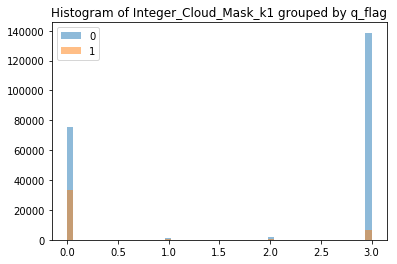

In [63]:
hist_df(df, var = "Integer_Cloud_Mask_k1", by = "q_flag")

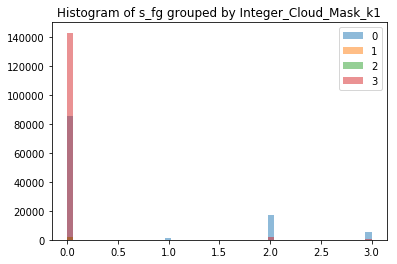

In [62]:
hist_df(df, var = "s_fg", by = "Integer_Cloud_Mask_k1")

In [65]:
pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1)

Integer_Cloud_Mask_k1,0,1,2,3
q_flag,,,,
0,75420,1488,1737,138702
1,33528,459,566,6410


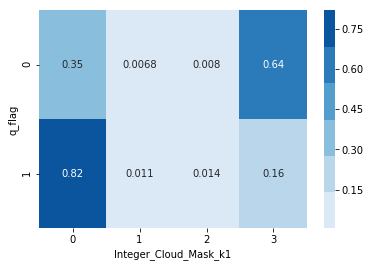

In [77]:
import seaborn as sns

ax = sns.heatmap(pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

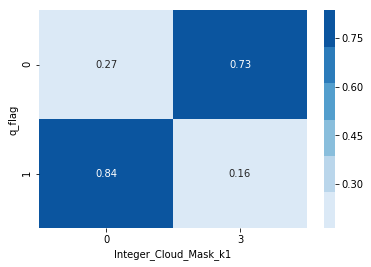

In [95]:
df2 = df[ df.delta_assim < 0.4 ]

ax = sns.heatmap(pd.crosstab(df2.q_flag,df2.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

### Functions I didn't use

In [37]:
# Do we use this function?
def orbit_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


def print_attrs(name, obj):
    '''
    Retrieves all attributes from hd5 file
    Use: f.visititems(print_attrs)
    '''
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

In [38]:
print_attrs(f_)

TypeError: print_attrs() missing 1 required positional argument: 'obj'